In [2]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm
            
# Machine learning 
import lightgbm as lgb
import joblib
#from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Define the Area-of-Interest (AOI):

### Get area boundary

Dimension of the area is 50871 x 36009 m2


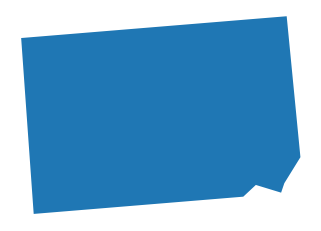

In [15]:
# Folder where data for running the notebook is stored
DATA_FOLDER = 'C:\data'

# Load geojson file
area = gpd.read_file(os.path.join(DATA_FOLDER, 'Drummond.geojson'))

# Convert CRS to UTM_18N
area_crs = CRS.UTM_18N
area = area.to_crs(crs={'init': CRS.ogc_string(area_crs)})

# Get the area shape in polygon format
area_shape = area.geometry.values.tolist()[-1]

# Plot area
area.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(area_shape.bounds[2] - area_shape.bounds[0],
                                                             area_shape.bounds[3] - area_shape.bounds[1]))

### Split to smaller tiles and choose a 3x3 area

In [24]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = BBoxSplitter([area_shape], area_crs, (17, 12))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 100  

# # Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
  
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(area_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = os.path.join(DATA_FOLDER, 'selected_3x3_bboxes.shp')
gdf.to_file(shapefile_name)

### Visualize the selection

In [28]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

1.002782972250043

(664976.8438703775, 720934.9303434283, 5066980.656891911, 5106590.409556526)

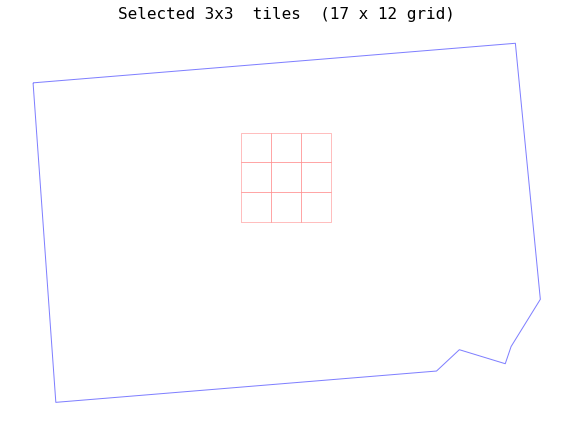

In [39]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 16}

# figure
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
area.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles  (17 x 12 grid)', fontdict=fontdict);
plt.axis('off')

## 2. - 4. Fill EOPatches with data:

### Define some needed custom EOTasks

In [40]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is assumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_feature_name = band_a.split('/')[0]
        self.band_b_feature_name = band_b.split('/')[0]
        self.band_a_feature_idx = int(band_a.split('/')[-1])
        self.band_b_feature_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_feature_name][..., self.band_a_feature_idx]
        band_b = eopatch.data[self.band_b_feature_name][..., self.band_b_feature_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

### Define the workflow tasks

In [41]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = os.path.join(DATA_FOLDER, 'eopatches')
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Reference map task

In [ ]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)